<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [2]:
# Descargar la carpeta de dataset
import os
import platform
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip   
else:
    print("El dataset ya se encuentra descargado")

--2022-11-13 18:46:21--  http://songs_dataset.zip/
Resolving songs_dataset.zip (songs_dataset.zip)... failed: Name or service not known.
wget: unable to resolve host address ‘songs_dataset.zip’
--2022-11-13 18:46:21--  https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip [following]
--2022-11-13 18:46:22--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (

In [3]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('/content/LOTR.txt', sep='/n', header=None)
df.head()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,0
0,An Unexpected Party
1,In a hole in the ground there lived a hobbit. ...
2,"the ends of worms and an oozy smell, nor yet a..."
3,in it to sit down on or to eat: it was a hobbi...
4,"It had a perfectly round door like a porthole,..."


In [4]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 46123


In [5]:
import random
rows_to_delete = random.sample(range(len(df)), int(0.80 * len(df)))
df = df.drop(rows_to_delete)

In [6]:
df = df.reset_index(drop=True)

In [7]:
df

,0
0,in it to sit down on or to eat: it was a hobbi...
1,"in), for these were the only ones to have wind..."
2,"looking over his garden and meadows beyond, sl..."
3,but also because they never had any adventures...
4,could tell what a Baggins would say on any que...
...,...
9220,say: do not weep; for not all tears are an evil.'
9221,But to Sam the evening deepened to darkness as...
9222,and as he looked at the grey sea he saw only a...
9223,the sigh and murmur of the waves on the shores...


### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [8]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_teokenize de nltk
from keras_preprocessing.sequence import pad_sequences # se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [9]:
# Ejemplo de como transformar una oración a tokens usando keras
text = df.loc[0,0]
text

'in it to sit down on or to eat: it was a hobbit hole, and that means comfort.'

In [10]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['in',
 'it',
 'to',
 'sit',
 'down',
 'on',
 'or',
 'to',
 'eat',
 'it',
 'was',
 'a',
 'hobbit',
 'hole',
 'and',
 'that',
 'means',
 'comfort']

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [11]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [12]:
# Demos un vistazo
sentence_tokens[:2]

[['in',
  'it',
  'to',
  'sit',
  'down',
  'on',
  'or',
  'to',
  'eat',
  'it',
  'was',
  'a',
  'hobbit',
  'hole',
  'and',
  'that',
  'means',
  'comfort'],
 ['in',
  'for',
  'these',
  'were',
  'the',
  'only',
  'ones',
  'to',
  'have',
  'windows',
  'deep',
  'set',
  'round',
  'windows']]

In [13]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [14]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences

[['in', 'it', 'to', 'sit'],
 ['it', 'to', 'sit', 'down'],
 ['to', 'sit', 'down', 'on'],
 ['sit', 'down', 'on', 'or'],
 ['down', 'on', 'or', 'to'],
 ['on', 'or', 'to', 'eat'],
 ['or', 'to', 'eat', 'it'],
 ['to', 'eat', 'it', 'was'],
 ['eat', 'it', 'was', 'a'],
 ['it', 'was', 'a', 'hobbit'],
 ['was', 'a', 'hobbit', 'hole'],
 ['a', 'hobbit', 'hole', 'and'],
 ['hobbit', 'hole', 'and', 'that'],
 ['hole', 'and', 'that', 'means']]

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [15]:
tok = Tokenizer() 

# El tokeinzer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [16]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[[14, 2, 1, 3],
 [2, 1, 3, 4],
 [1, 3, 4, 5],
 [3, 4, 5, 6],
 [4, 5, 6, 1],
 [5, 6, 1, 7],
 [6, 1, 7, 2],
 [1, 7, 2, 8],
 [7, 2, 8, 9],
 [2, 8, 9, 10],
 [8, 9, 10, 11],
 [9, 10, 11, 12],
 [10, 11, 12, 13],
 [11, 12, 13, 15]]

In [17]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

14


In [18]:
# Cantidad de veces que aparece cada palabra
print(len(tok.word_counts))

15


In [19]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'to': 1, 'it': 2, 'sit': 3, 'down': 4, 'on': 5, 'or': 6, 'eat': 7, 'was': 8, 'a': 9, 'hobbit': 10, 'hole': 11, 'and': 12, 'that': 13, 'in': 14, 'means': 15}


In [20]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'in': 1, 'sit': 4, 'to': 7, 'it': 6, 'down': 4, 'on': 4, 'or': 4, 'eat': 4, 'was': 4, 'a': 4, 'hobbit': 4, 'hole': 4, 'and': 3, 'that': 2, 'means': 1})


### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [21]:
# Vistazo a las primeras filas
df.loc[:15,0]

0     in it to sit down on or to eat: it was a hobbi...
1     in), for these were the only ones to have wind...
2     looking over his garden and meadows beyond, sl...
3     but also because they never had any adventures...
4     could tell what a Baggins would say on any que...
5     him. This is a story of how a Baggins had an a...
6     The mother of our particular hobbit … what is ...
7     People, as they call us. They are (or were) a ...
8     small river that ran at the foot of The Hill. ...
9     remained that the Tooks were not as respectabl...
10    luxurious hobbit hole for her (and partly with...
11    the beautiful hobbit hole built by his father,...
12    there was less noise and more green, and the h...
13    (neatly brushed)  Gandalf came by. Gandalf! If...
14    I want not; or that you feel good this morning...
15    tobacco out of doors, into the bargain. If you...
Name: 0, dtype: object

In [22]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

'in it to sit down on or to eat: it was a hobbit hole, and that means comfort. in), for these were the only ones to have windows, deep set round windows looking over his garden and meadows beyond, sloping down to the river. but also because they never had any adventures or did anything unexpected: you could tell what a Baggins would say on any question without the bother of asking him. This is a story of how a Baggins had an adventure, found himself doing and The mother of our particular hobbit … what is a hobbit? I suppose hobbits People, as they call us. They are (or were) a little people, about half our height, small river that ran at the foot of The Hill. It was often said (in other families) that remained that the Tooks were not as respectable as the Bagginses, though they luxurious hobbit hole for her (and partly with her money) that was to be found the beautiful hobbit hole built by his father, which I have just described for you, there was less noise and more green, and the hob

In [23]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['in',
 'it',
 'to',
 'sit',
 'down',
 'on',
 'or',
 'to',
 'eat',
 'it',
 'was',
 'a',
 'hobbit',
 'hole',
 'and',
 'that',
 'means',
 'comfort',
 'in',
 'for']

In [24]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 117661


In [25]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [26]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['in', 'it', 'to', 'sit'],
 ['it', 'to', 'sit', 'down'],
 ['to', 'sit', 'down', 'on'],
 ['sit', 'down', 'on', 'or'],
 ['down', 'on', 'or', 'to'],
 ['on', 'or', 'to', 'eat'],
 ['or', 'to', 'eat', 'it'],
 ['to', 'eat', 'it', 'was'],
 ['eat', 'it', 'was', 'a'],
 ['it', 'was', 'a', 'hobbit'],
 ['was', 'a', 'hobbit', 'hole'],
 ['a', 'hobbit', 'hole', 'and'],
 ['hobbit', 'hole', 'and', 'that'],
 ['hole', 'and', 'that', 'means'],
 ['and', 'that', 'means', 'comfort'],
 ['that', 'means', 'comfort', 'in'],
 ['means', 'comfort', 'in', 'for'],
 ['comfort', 'in', 'for', 'these'],
 ['in', 'for', 'these', 'were'],
 ['for', 'these', 'were', 'the']]

In [27]:
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[8, 9, 4, 670],
 [9, 4, 670, 52],
 [4, 670, 52, 23],
 [670, 52, 23, 36],
 [52, 23, 36, 4],
 [23, 36, 4, 690],
 [36, 4, 690, 9],
 [4, 690, 9, 10],
 [690, 9, 10, 5],
 [9, 10, 5, 212],
 [10, 5, 212, 757],
 [5, 212, 757, 2],
 [212, 757, 2, 11],
 [757, 2, 11, 1633],
 [2, 11, 1633, 1134],
 [11, 1633, 1134, 8],
 [1633, 1134, 8, 19],
 [1134, 8, 19, 198],
 [8, 19, 198, 27],
 [19, 198, 27, 1]]

In [28]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 117657


### 3 - Input y target

In [29]:
# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])
ex

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [30]:
# Con numpy es muy fácil realizar el slicing de vectores
print("Dimension:", ex.shape)
print("Todos los elementos:", ex)
print("Todos los elementos menos el último:", ex[:, :-1])

Dimension: (2, 4)
Todos los elementos: [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último: [[1 2 3]
 [5 6 7]]


In [31]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [32]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(117657, 3)
(117657,)


In [33]:
# Palabras del vocabulario
tok.index_word

{1: 'the',
 2: 'and',
 3: 'of',
 4: 'to',
 5: 'a',
 6: 'he',
 7: "'",
 8: 'in',
 9: 'it',
 10: 'was',
 11: 'that',
 12: 'i',
 13: 'they',
 14: 'you',
 15: 'his',
 16: 'but',
 17: 'said',
 18: 'not',
 19: 'for',
 20: 'as',
 21: 'had',
 22: 'is',
 23: 'on',
 24: 'at',
 25: 'with',
 26: 'there',
 27: 'were',
 28: 'have',
 29: 'him',
 30: 'all',
 31: 'them',
 32: 'we',
 33: 'be',
 34: 'from',
 35: 'now',
 36: 'or',
 37: 'their',
 38: 'no',
 39: 'are',
 40: 'if',
 41: 'up',
 42: 'out',
 43: 'will',
 44: 'then',
 45: 'frodo',
 46: 'by',
 47: 'this',
 48: 'great',
 49: 'could',
 50: 'so',
 51: 'your',
 52: 'down',
 53: 'came',
 54: 'long',
 55: 'do',
 56: 'would',
 57: 'my',
 58: 'into',
 59: 'like',
 60: 'what',
 61: 'some',
 62: 'been',
 63: 'gandalf',
 64: 'when',
 65: 'come',
 66: 'more',
 67: 'me',
 68: 'again',
 69: 'sam',
 70: 'before',
 71: 'one',
 72: 'about',
 73: 'back',
 74: 'away',
 75: 'see',
 76: 'go',
 77: 'any',
 78: 'us',
 79: 'far',
 80: 'still',
 81: 'did',
 82: 'only',
 8

In [34]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

8193

In [35]:
# Transformar los datos a oneHotEncoding
y_data = to_categorical(y_data_int-1, num_classes=vocab_size)

In [36]:
# En el caso anterior explota porque y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [37]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(117657, 8193)

### 4 - Entrenar el modelo

In [38]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [39]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

8193

In [40]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(128)) # La última capa LSTM no lleva return_sequences
model.add(Dense(64, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 5)              40970     
                                                                 
 lstm (LSTM)                 (None, 3, 128)            68608     
                                                                 
 dropout (Dropout)           (None, 3, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 8193)              532545    
                                                                 
Total params: 781,963
Trainable params: 781,963
Non-trai

In [41]:
hist = model.fit(x_data, y_data, epochs=120, validation_split=0.2)

Epoch 1/120
2942/2942 [==============================] - 37s 10ms/step - loss: 6.6238 - accuracy: 0.0593 - val_loss: 6.4922 - val_accuracy: 0.0654
Epoch 2/120
2942/2942 [==============================] - 29s 10ms/step - loss: 6.2645 - accuracy: 0.0715 - val_loss: 6.4452 - val_accuracy: 0.0788
Epoch 3/120
2942/2942 [==============================] - 28s 10ms/step - loss: 6.0243 - accuracy: 0.0818 - val_loss: 6.3844 - val_accuracy: 0.0942
Epoch 4/120
2942/2942 [==============================] - 30s 10ms/step - loss: 5.8345 - accuracy: 0.0942 - val_loss: 6.4118 - val_accuracy: 0.1007
Epoch 5/120
2942/2942 [==============================] - 29s 10ms/step - loss: 5.6873 - accuracy: 0.1023 - val_loss: 6.4304 - val_accuracy: 0.1096
Epoch 6/120
2942/2942 [==============================] - 29s 10ms/step - loss: 5.5530 - accuracy: 0.1096 - val_loss: 6.4848 - val_accuracy: 0.1123
Epoch 7/120
2942/2942 [==============================] - 29s 10ms/step - loss: 5.4233 - accuracy: 0.1156 - val_loss: 6

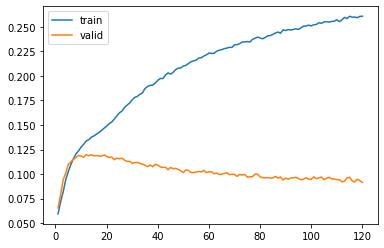

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [43]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [44]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

     |████████████████████████████████| 11.6 MB 7.9 MB/s 
     |████████████████████████████████| 84 kB 3.3 MB/s 
     |████████████████████████████████| 106 kB 12.8 MB/s 
     |████████████████████████████████| 55 kB 4.3 MB/s 
     |████████████████████████████████| 272 kB 64.9 MB/s 
     |████████████████████████████████| 213 kB 65.0 MB/s 
     |████████████████████████████████| 56 kB 5.9 MB/s 
     |████████████████████████████████| 54 kB 3.9 MB/s 
     |████████████████████████████████| 84 kB 3.5 MB/s 
     |████████████████████████████████| 2.3 MB 74.1 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 80 kB 11.2 MB/s 
     |████████████████████████████████| 68 kB 7.9 MB/s 
     |████████████████████████████████| 46 kB 5.1 MB/s 
     |████████████████████████████████| 4.1 MB 51.9 MB/s 
     |████████████████████████████████| 856 kB 66.4 MB/s 
     |████████████████████████████████| 593 kB 75.1 MB/s 


In [51]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `layout` parameter is deprecated, and it has no effect
  warnings.warn(value)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().

Using Embedded Colab Mode (NEW). If you have issues, please use share=True and file an issue at https://github.com/gradio-app/gradio/
Note: opening the browser inspector may crash Embedded Colab Mode.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 16ms/step
Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x7fd811b2ce90>, 'http://127.0.0.1:7860/', None)

### 6 - Generación de secuencias nuevas

In [46]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [47]:
input_text='In a hole in the ground there lived a'

generate_seq(model, tok, input_text, max_length=8, n_words=1)

1/1 [==============================] - 1s 633ms/step


'In a hole in the ground there lived a hoards'

### 7 - Conclusiones

Se utilizó un txt de la novela El Señor de los Anillos para entrenar el modelo. Se optó por este texto porque es muy extenso y se creyó que iba a ser buena idea. Sin embargo, se enfrentaron varias problemas. Uno de ellos fue la limitación del RAM de 12 GB que ofrece Google Colab, que no fue suficiente y se crasheaba la página. Es por ello que se probaron recortes de oraciones aleatorias hasta que se encontró el punto justo que utilizaba 11.50GB de RAM. Lamentablemente, este punto se alcanzó recortando el 80% del corpus.

Se probaron varios modelos y ninguno de ellos performó bien.

Entre los modelos que se tomaron registro, se intentó con 128 neuronas para la capa LSTM y 64 para la capa densa; y otro modelo con 64 neuronas para la capa LSTM y 32 para la capa densa.

Para todos los modelos testeados, el error en validación auemntaba conforme disminuía el error en entrenamiento. Esto es señal de sobreajuste. Para evitar un mayor sobre ajuste, también se probaron diferentes valores de dropout.

Para el último modelo entrenado, se probaron las siguientes frases extraidas del corpus. La primera de ellas muestra el valor real y la segunda muestra el output del modelo. No se esperaba que dé exactamente la misma palabra porque solo tomaba ne cuenta la últimas 4 palabras y realizaba una predicción en base a éstas, y en muchas ocasiones esa predicción puede ser cualquier palabra que tenga sentido con la oración. A continuación, se muestran los ejemplos:

1) In a hole in the ground there lived a HOBBIT ---- In a hole in the ground there lived a TALKING.

2) the ends of worms and an oozy SMELL ---- the ends of worms and an oozy WATCHER.

3) Yes, yes, but that was LONG ---- Yes, yes, but that was O.

En el primer ejemplo se esperaba un sustantivo, no necesariamente HOBBIT. Se obtuvo un sustantivo un poco confuso (TALKING) y con poca coherencia con el contexto. EN el segundo ejemplo se esperaba también un sustantivo que conecte con la palabra OOZY, pero se obtuve la palabra WATCHER que poco sentido tenía.
Por ultimo, en el ejemplo tres, se espraba un adjetivo (aunque también pudo haber sido un sustantivo). Independientemente de ello, se obtuve la letra O, cuando la palabra con sentido era LONG.

Se utilizó una ventana de 4 palabras para predecir la quinta. Se pudieorn haber probado otras ventanas más extensas, con por ejemplo 8 palabras, pero se sospechaba que no iba a mejorar el modelo. Porque lo que se pretendía no era que sea muy razonable con toda la oración en sí, sino solamente que esa palabra tenga sentido únicamente. Pero no se logró.

Se utilizó GPU para entrenar 120 épocas con 128 neuronas en cada capa y se demoró alrededor de 1 hora. Para mejorar el modelo, se podrían utilizar más neuronas, más épocas, y principalmente un mejor corpus.